### Bonus Questions:

If you complete all of the above, you can attempt these challenging bonus questions.

Open Secrets also gives a detailed breakdown of contributions by source. For example, for Tennessee's second district, this is located at https://www.opensecrets.org/races/candidates?cycle=2020&id=TN02&spec=N

Scrape these pages to get information on contributions by source. See if you can find anything interesting in terms of the source of contributions. Some examples to get you started:
* What does the overall distribution of funding sources look like?
* Is there any detectable difference in contribution sources between Democrat and Republican candidates?
* Do the funding sources for either the winning candidate or incumbent candidate differ from the other candidates?

In [4]:
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
all_contributions_by_source = pd.read_csv("Write_Data_Here/all_contributions_by_source.csv")

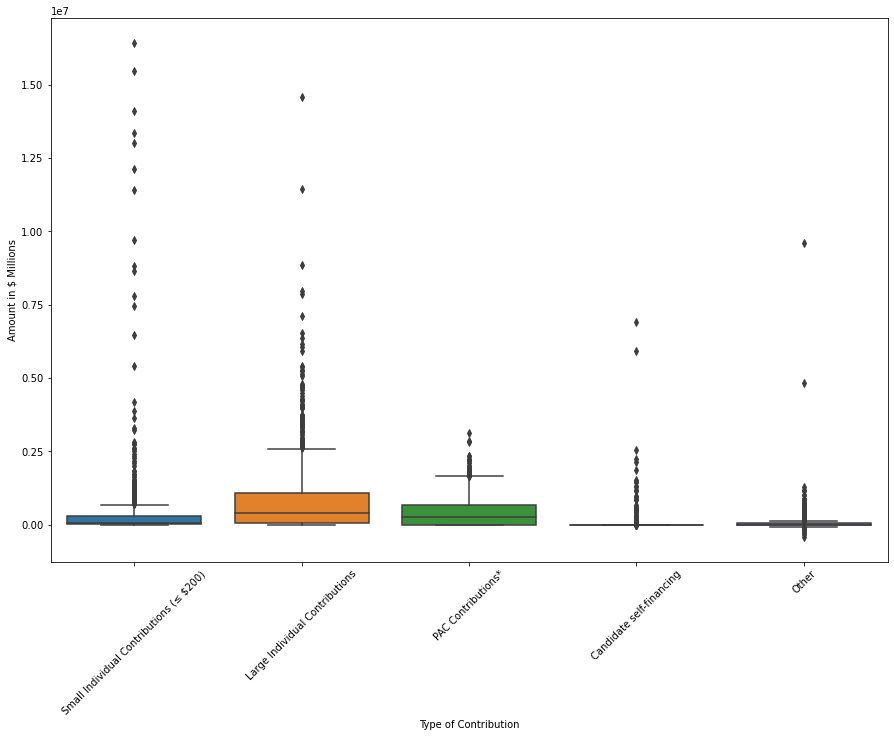

In [13]:
# What does the overall distribution of funding sources look like?
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(data = all_contributions_by_source, x = "Type of Contribution", y = "Amount", ax = ax)
plt.xticks(rotation = 45)
plt.ylabel('Amount in $ Millions');